# Foundations of Computational Economics #22

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Successive approximations (fixed point iterations)

<img src="_static/img/lecture.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/AQt9Q9qc3io](https://youtu.be/AQt9Q9qc3io)

Description: Scalar and multivariate solver. Equilibrium in market of platforms.

### What is successive approximations?

- root finding method for the equations of the type  


$$
x = F(x) \quad \Leftrightarrow \quad F(x) - x = 0
$$

- **fixed point equation**  
- conversion is always possible (although does not guaranteed to work as we’ll see below)  


$$
g(x) = 0 \quad \Leftrightarrow \quad \underbrace{g(x) + x}_{F(x)} = x
$$

#### Main algorithm

$$
x = F(x) \rightarrow x_{n+1} = F(x_n)
$$

1. Initialize the iterations at $ x_0 $  
1. Iterate on $ x_{i+1} = F(x_i) $ until $ x_{i+1} $ is close enough to $ x_i $  

#### Stationary distribution of Markov chains

For aperiodic and irreducible Markov chain with transition probability matrix $ P $, the stationary distribution
is given by $ \psi^\star = \psi^\star P $

Successive approximation applicable with $ F(\psi) = \psi P $

Have seen this is last two videos

#### Will it converge?

*The central question for the successive approximations method*

- it will from any starting point for aperiodic and irreducible Markov chains  
- but what are the general conditions?  


Will come back to this question in general terms when talking about the dynamic models and Bellman operator
(which is a *contraction mapping*)

#### Scalar example

$$
\frac{1}{2} - \exp\big(-(x-2)^2\big) = 0
$$

Using the trick above convert to $ x = F(x) $

$$
F(x) = x - \exp\big(-(x-2)^2\big) + \frac{1}{2}
$$

$$
x_{i+1} = x_i - \exp\big(-(x_i-2)^2\big) + \frac{1}{2}
$$

In [1]:
import numpy as np
eq = lambda x:  - np.exp(-(x-2)**2) + .5  # initial equation
F = lambda x: x - np.exp(-(x-2)**2) + .5  # fixed point equation
dF = lambda x: 1 + np.exp(-(x-2)**2)*2*(x-2)  # derivative (for later)

In [2]:
def solve_sa(F,x0,tol=1e-6,maxiter=100,callback=None):
    '''Computes the solution of fixed point equation x = F(x)
    with given initial value x0 and algorithm parameters
    Method: successive approximations
    '''
    for i in range(maxiter):  # main loop
        x1 = F(x0)  # update approximation
        err = np.amax(np.abs(x0-x1))  # allow for x to be array
        if callback != None: callback(iter=i,err=err,x=x1,x0=x0)
        if err<tol:
            break  # break out if converged
        x0 = x1  # get ready to the next iteration
    else:
        raise RuntimeError('Failed to converge in %d iterations'%maxiter)
    return x1

In [3]:
def printme(**kwargs):
    print('iter %d, x = %1.10f (err = %1.3e)'%(kwargs['iter'],kwargs['x'],kwargs['err']))
x = solve_sa(F,x0=1.0,tol=1e-10,callback=printme)
print('Residual in the original equation = %1.5e' % eq(x))
# try different starting points, including >2.8

iter 0, x = 1.1321205588 (err = 1.321e-01)
iter 1, x = 1.1612700962 (err = 2.915e-02)
iter 2, x = 1.1664038940 (err = 5.134e-03)
iter 3, x = 1.1672707853 (err = 8.669e-04)
iter 4, x = 1.1674161464 (err = 1.454e-04)
iter 5, x = 1.1674404922 (err = 2.435e-05)
iter 6, x = 1.1674445689 (err = 4.077e-06)
iter 7, x = 1.1674452515 (err = 6.826e-07)
iter 8, x = 1.1674453659 (err = 1.143e-07)
iter 9, x = 1.1674453850 (err = 1.914e-08)
iter 10, x = 1.1674453882 (err = 3.205e-09)
iter 11, x = 1.1674453887 (err = 5.366e-10)
iter 12, x = 1.1674453888 (err = 8.986e-11)
Residual in the original equation = 1.50464e-11


In [4]:
# plot to understand what is going on!
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

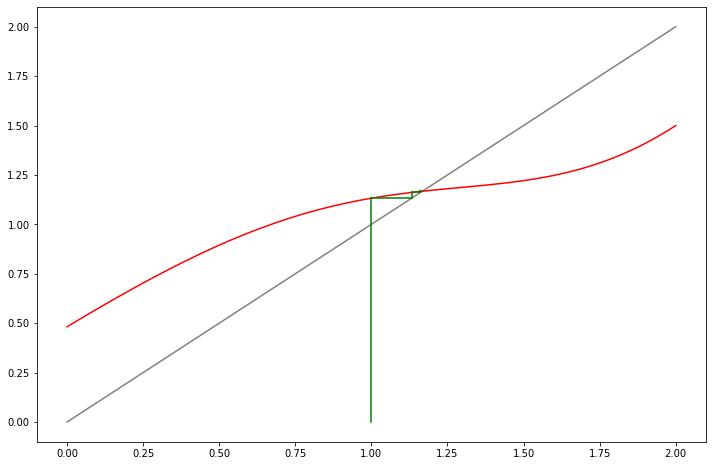

In [5]:
a,b,x0 = 0,2,1.0  # bounds and starting value
# a,b,x0 = 0,2.5,2.75
# a,b,x0 = 0,5,2.85
xd = np.linspace(a,b,100)  # x grid
plt.plot([a,b],[a,b],c='grey')  # plot the 45 degree line
plt.plot(xd,F(xd),c='red')  # plot the function
def plot_step(**kwargs):
    if plot_step.counter < 10:
        if plot_step.counter == 0:
            x,f = kwargs['x0'],F(kwargs['x0'])
            plt.plot([x,x],[0,f],c='green')  # initial vertical line
            plt.plot([x,f],[f,f],c='green')
        plot_step.counter += 1
        x,f = kwargs['x'],F(kwargs['x'])
        plt.plot([x,x],[x,f],c='green')  # vertical line
        plt.plot([x,f],[f,f],c='green')  # horizontal line
plot_step.counter = 0  # new public attribute
x = solve_sa(F,x0,tol=1e-10,callback=plot_step)
plt.show()

#### Condition for convergence in scalar case

$$
|F'(x^\star)| < 1
$$

- where $ x^\star $ is the solution/root  
- **stable solution**  

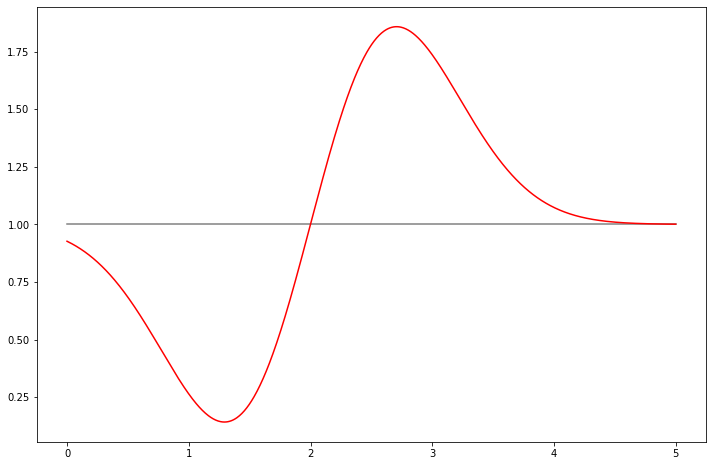

In [6]:
a,b = 0,5
xd = np.linspace(a,b,1000)
plt.plot([a,b],[1,1],c='grey')  # 1 line
plt.plot(xd,dF(xd),c='red')  # plot the derivative
plt.show()

#### Limitations of successive approximations method

- Only stable solutions can be computed with SA  
- Starting values matter for convergence!  
- Also, only linear (slow) convergence to the solution when it does converge  


But very easy to implement!

### Multivariate example: platform market equilibrium

- Platform is product or service with *network effects*, i.e. value (for firm and users) is generated from the interaction of users, and therefore depends on the size of the user base.  
- Examples: game consoles, interface standards, social media, two-sided market platforms (Amazon, Ebay), peer-to-peer markets (Uber, AirBnB)  
- Because of better experience of the users on larger platforms, platform markets tend to monopolization (*tipping markets*)  
- Yet, there can be opposite forces as well: heterogeneous preferences or *congestion* in too large platforms  
- Many different aspects (see further learning resources), we’ll look at a simple example, focusing on consumer choice and equilibrium  

#### The model

- $ m $ products, $ i=1,\dots,m $  
- unit mass of consumers of $ n $ types with different preferences over the product  
- $ p_j $ are fractions of consumer types in the population, $ j=1,\dots,n $  
- utility function of consumers of type $ j \in 1,\dots,n $ from product $ i \in 1,\dots,m $ is given by  


$$
u_{ij} = c_{ij} + s_i,
$$

- $ c_{ij} $ are *valuations* of each product by each of the consumer type  
- $ s_i $ are market shares of each product, increase utility when more people are using the same platform  

#### Choice probabilities

Standard random utility framework with logit choice probabilities

- value of choice $ U_{ij} = u_{ij} + \epsilon[i] $ is effected by the random factors  
- one $ \epsilon[i] $ for each product choice, forming the vector $ \epsilon = (\epsilon[1],\dots,\epsilon[m]) $  
- elements of $ \epsilon $ are extreme value type I (EV1) random components of the utility, iid between consumers and products  


$$
P_{ij} = \frac{\exp(u_{ij})}{\sum_{k=1}^m \exp(u_{kj})}
= \frac{\exp(u_{ij}-\alpha)}{\sum_{k=1}^m \exp(u_{kj}-\alpha)}, \; \forall \alpha
$$

#### Market shares

- assume choice is made once, and no changes are made afterwards  
- under the assumption of unit mass of consumers we have  


$$
s_i = \sum_{j=1}^n p_j P_{ij} = P \cdot p
$$

- simple matrix product, assuming $ p $ is a column-vector  

#### Fixed point equation

Combining the last three expressions:

$$
u_{ij} = c_{ij} + \sum_{t=1}^n p_t \frac{\exp(u_{it})}{\sum_{k=1}^m \exp(u_{kt})}
$$

- $ mn $ fixed point equations  
- fixed point in the ($ mn $)-dimensional space of $ u_{ij} $  

In [7]:
class model:
    '''Simple platform equilibrium model'''

    def __init__(self,m=2,n=2):
        '''Define default model parameters'''
        self.m,self.n = m,n  # number of products and consumer types
        self.c = np.random.uniform(size=(m,n))    # utilities (random uniform)
        self.p = np.random.dirichlet(np.ones(n))  # population composition (from symmetric Dirichlet distribution)

    def __repr__(self):
        return 'Number of platform products = {:d}\nNumber of consumer types = {:d}\nPopulation composition = {}\nUtilities:\n{}'.format(self.m,self.n,self.p,self.c)

    def ccp(self,u):
        '''Conditional choice probabilities, assuming choices in row'''
        u = np.asarray(u).reshape((self.m,self.n))   # convert to matrix
        u = u - np.amax(u,axis=0) # de-max by column (avoid exp of large numbers)
        e = np.exp(u)
        esum = e.sum(axis=0)  # sums of exps
        return e/esum         # vector of choice probabilities

    def shares(self,pr):
        '''Market shares from choice probabilities'''
        out = pr @ self.p  # one-dim vector
        return out[:,np.newaxis]  # column vector

    def F(self,u):
        '''Fixed point equation u=F(u)'''
        pr = self.ccp(u)     # matrix of choice probabilities
        sh = self.shares(pr) # market shares
        u1 = self.c + sh     # updated utilities
        return u1.reshape(self.m*self.n) # return one dimensional array

In [8]:
def printiter(**kwargs):
    print('iter %d, err = %1.3e'%(kwargs['iter'],kwargs['err']))
md = model(m=3,n=2)
print(md)
print('SA from zero utilities:')
x = solve_sa(md.F,x0=np.zeros(md.n*md.m),callback=printiter)
print('Equilibrium found!')
ccp = md.ccp(x)
shares = md.shares(ccp).squeeze()  # make one-dim array
print('Equilibrium choice probabilities:',ccp,'Equilibrium market shares:',shares,sep='\n')

Number of platform products = 3
Number of consumer types = 2
Population composition = [0.07395594 0.92604406]
Utilities:
[[0.71361939 0.51952517]
 [0.27539451 0.30194578]
 [0.73362029 0.39378844]]
SA from zero utilities:
iter 0, err = 1.067e+00
iter 1, err = 3.914e-02
iter 2, err = 1.352e-02
iter 3, err = 4.718e-03
iter 4, err = 1.658e-03
iter 5, err = 5.859e-04
iter 6, err = 2.080e-04
iter 7, err = 7.412e-05
iter 8, err = 2.650e-05
iter 9, err = 9.496e-06
iter 10, err = 3.411e-06
iter 11, err = 1.227e-06
iter 12, err = 4.422e-07
Equilibrium found!
Equilibrium choice probabilities:
[[0.39502849 0.39314102]
 [0.2270464  0.28174725]
 [0.37792511 0.32511173]]
Equilibrium market shares:
[0.39328061 0.2777018  0.32901759]


### Further learning resources

- Oscar Veliz videos on fixed point iterations
  [https://www.youtube.com/watch?v=OLqdJMjzib8](https://www.youtube.com/watch?v=OLqdJMjzib8)
  [https://www.youtube.com/watch?v=FyCviw2ZA2o](https://www.youtube.com/watch?v=FyCviw2ZA2o)  
- Non-technical review of platform competition
  [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3502964](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3502964)  
- Blog posts on platform competition by Paul Belleflamme
  [http://www.ipdigit.eu/2020/04/an-introduction-to-the-economics-of-platform-competition-part-1/](http://www.ipdigit.eu/2020/04/an-introduction-to-the-economics-of-platform-competition-part-1/)
  [http://www.ipdigit.eu/2020/04/an-introduction-to-the-economics-of-platform-competition-part-2/](http://www.ipdigit.eu/2020/04/an-introduction-to-the-economics-of-platform-competition-part-2/)
  [http://www.ipdigit.eu/2020/04/an-introduction-to-the-economics-of-platform-competition-part-3/](http://www.ipdigit.eu/2020/04/an-introduction-to-the-economics-of-platform-competition-part-3/)  